In [1]:
import warnings
warnings.simplefilter(action='ignore') #IGNORE ALL THE WARNINGS. I KNOW IT'S BAD BUT THERE ARE TOO MANY OF THEM

import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import matplotlib.animation as animation
import random
from geographiclib.geodesic import Geodesic
import time
import math

In [2]:
#Setting important constants

velocity = 14 # 50 kph to mps
number_of_vehicles = 50

In [3]:
#Simplifications, good functions

def lat_to_km(lat1, lon1, lat2, lon2): #giving distance given the curvature of the Earth, earth_radius=6371009 change the value to km to get km.
    distance = ox.distance.great_circle_vec(lat1, lon1, lat2, lon2)
    return distance #in meters by default

def get_position_of_node(graph, node):
    """
    Get latitude and longitude given node ID
    :param graph: object: OGraph object from osm_request
    :param node:      graphml node ID
    :return position: array:    [latitude, longitude]
    """
    # note that the x and y coordinates of the graph.nodes are flipped
    # this is possibly an issue with the omnx graph.load_graphml method
    # a correction is to make the position tuple be (y, x) as below
    position = np.array([graph.nodes[node]['x'], graph.nodes[node]['y']])
    return position

def getAllNodesIDs(graph):
    nodesList = []
    for i in G.nodes:
        nodesList.append(i)
    return nodesList

def find_cars(init_node, end_node, cars):
    print("Nothing so far")


In [4]:
class Car:
    """
    Class of a car driver initially assigned with the current node and the target node
    """
    def __init__(self, graph, init_node, target_node, color = "cyan"): #add color later 
        """
        :param init_node: node ID of the initial node
        :param target_node: node ID of the target node
        """
        self.current_position = get_position_of_node(graph, init_node)
        self.color = color
        
        self.target_position = get_position_of_node(graph, target_node)
        self.target_node = target_node
        
        try:
            self.all_target_nodes = nx.shortest_path(graph, init_node, target_node)
        except:
            self.all_target_nodes = []
            self.target_node = init_node
        self.all_target_nodes = self.all_target_nodes[1:]
        
        self.current_node = init_node
        
        self.is_on_node = True # A boolean variable to check if the car is on intersection 
        
        self.waiting_count = 0 # Number of ticks to wait
    
    def wait (self, tick_number):
        self.waiting_count = tick_number            
        
    def update_pos (self, new_pos): #manual update of position
        self.current_position = new_pos
        
    def move_towards_node(self, local_target_node, time = 1): #without considering other drivers' behavior so far
        tx, ty = get_position_of_node(G, local_target_node)
        ix, iy = self.current_position
        
        real_dist = lat_to_km (ix, iy, tx, ty)
        #print("real distance = ", real_dist)
        if real_dist >= (velocity * time):
            map_dist = math.sqrt( (tx-ix)**2 + (ty- iy)**2 )     
            traveling_dist = map_dist / real_dist * velocity * time
            
            angle = math.atan( (ty - iy) / (tx - ix) )
            if (tx - ix) < 0:
                angle += math.pi
            new_x = ix + traveling_dist * math.cos(angle)
            new_y = iy + traveling_dist * math.sin(angle)
            #print("map_dist = ", map_dist, "\ntravelling dist", traveling_dist, ix, iy, new_x, new_y)
            self.current_position = np.array([new_x, new_y])
            self.is_on_node = False # Still moving, not on node
        else:
            self.current_position = tx, ty
            self.current_node = local_target_node
            self.is_on_node = True # Is on node
    
    
    def finished (self):
        """
        Returns boolean true if the destination is reached, false if not
        """
        if self.current_node == self.target_node:
            return True
        else:
            return False
    
    def iter_to_target(self):
        if not self.finished():
            if self.waiting_count == 0: 
                self.move_towards_node(self.all_target_nodes[0])
                if self.current_node == self.all_target_nodes[0]:
                    #print (self.all_target_nodes[0], "is reached")
                    self.all_target_nodes = self.all_target_nodes[1:]
            else:
                self.waiting_count -= 1
    
    def get_status(self):
        """
        Returns a dictionary with the status information about an object
        """
        self.status = {"CurrentNode": self.current_node,
                 "CurrentPosition": self.current_position,
                 "TargetNode": self.target_node,
                 "TargetPosition": self.target_position,
                 "OnNode": self.is_on_node}
        return self.status
    
    def get_position(self):
        return self.current_position
    
    def draw_on_map(self, ax):
        xx, yy = self.get_position()
        ax.scatter(xx, yy, c = self.color)
        

In [5]:
class TrafficLight:
    """Class for traffic lights"""
    def __init__ (self, graph, node_id, time = 5):
        self.state = random.randint(0, 1) # Initialize with random, green (0) or red (1) 
        self.ticks = 0
        self.id = node_id
        self.graph = graph
        self.time = time
    
    def get_position(self):
        return get_position_of_node(self.graph, self.id)
    
    def one_tick(self):
        self.ticks += 1
        if self.ticks % self.time == self.time - 1: 
            if self.state == 0: self.state = 1
            else: self.state = 0
    
    def get_color(self):
        if self.state: 
            return "red"
        else:
            return "green"
    
    def draw_on_map(self, ax):
        xx, yy = self.get_position()
        ax.scatter(xx, yy, c = self.get_color())
        

In [6]:
#Uploading coordinates. To change, modify config file

f = open('.\\config\\coordinates.txt')
boundtemp = []
for line in f:
    boundtemp.append(float(line[0:len(line)-1]))

boundaries = {"north": boundtemp[0], #Coordinates of Hong Kong Happy Valley
              "south": boundtemp[1],
              "east": boundtemp[2],
              "west": boundtemp[3] }
print (boundaries)

f.close()

#Initializing the map 

geod = Geodesic.WGS84
G = ox.graph_from_bbox(boundaries["north"], boundaries["south"], boundaries["east"], boundaries["west"], network_type='drive') 
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

projected_graph = ox.project_graph(G, to_crs="EPSG:3395")
Gc = ox.consolidate_intersections(projected_graph, dead_ends=True)
edges = ox.graph_to_gdfs(ox.get_undirected(Gc), nodes=False)

{'north': 22.27049, 'south': 22.26206, 'east': 114.19605, 'west': 114.1792}


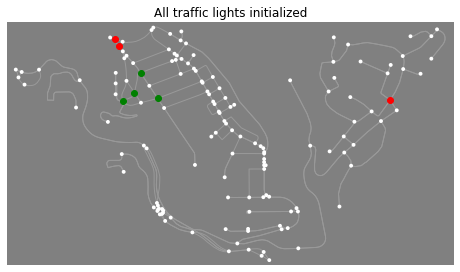

In [7]:
# Get all nodes ids in a List ========================
nodes_list = getAllNodesIDs(G)

# Get all nodes and edges in a dataframe
nodes, edges = ox.graph_to_gdfs(G)

# Initialize all nodes suitable for traffic lights
signal_nodes = nodes.loc[nodes['street_count'] >= 4]

traffic_lights = []

for i in signal_nodes.index:
    traffic_lights.append(TrafficLight(G, i, time = 4))
# ====================================================

fig, ax = ox.plot_graph(G, show=False, close=False)
ax.set_facecolor('grey')

ax.set_title("All traffic lights initialized")

for i in traffic_lights:
    i.draw_on_map(ax)

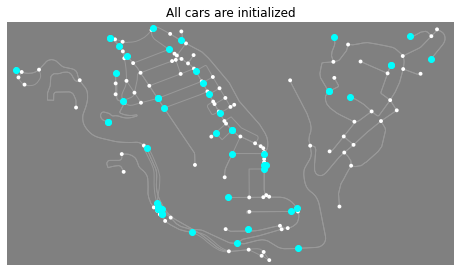

In [8]:
list_of_vehicles = []
for i in range(number_of_vehicles):
    init_node = random.randint(0, len(nodes_list)-1)
    target_node = random.randint(0, len(nodes_list)-1)
    list_of_vehicles.append(Car(G, nodes_list[init_node], nodes_list[target_node]))
    
fig, ax = ox.plot_graph(G, show=False, close=False)
ax.set_facecolor('grey')

ax.set_title("All cars are initialized")

for i in list_of_vehicles:
    i.draw_on_map(ax)

In [110]:
# Setting up a datastructure for each node

# All nodes where the cars are waiting
# Creating a dictionary for all nodes to contain the information about the cars on a certain node



"""
params:
Cars: The list of cars waiting on this node
IsTrafficLight: boolean whether the node has a traffic light

If there is traffic light
TrafficLight: an object of the class TrafficLight 

Example:
nodes_info["NODENAME"]["IsTrafficLight"]
"""
def update_nodes_info():
    car_nodes = []

    for car in list_of_vehicles:
        if car.get_status()["OnNode"]: 
            car_nodes.append(car.get_status()["CurrentNode"])

    # Check if a car is currently on the same node as another car ######################
    
    nodes_dict = {}
    for node in nodes.index:
        
        # Store the IDs of all the cars waiting on a certain node
        #nodes_dict[node] = {"Cars" : [i for i in range(len(car_nodes)) if car_nodes[i] == node]}
        nodes_dict[node] = {}
        
        jam = []
        for car in list_of_vehicles:
            if car.get_status()["OnNode"]: 
                if car.get_status()["CurrentNode"] == node:
                    jam.append(list_of_vehicles.index(car))
        
        nodes_dict[node]["Cars"] = jam
        
        # Store other information about the node
        if node in signal_nodes.index: 
            nodes_dict[node]["IsTrafficLight"] = True
            nodes_dict[node]["TrafficLight"] = TrafficLight (G, node, time = 4)
        else: nodes_dict[node]["IsTrafficLight"] = False
    
    return nodes_dict



In [111]:
"""
Simulation
"""
num_of_iters = 0
all_iters = []
init_list = list_of_vehicles.copy()

while len(list_of_vehicles) != 0:
    for car in list_of_vehicles:

        nodes_info = update_nodes_info()

        status = car.get_status()
        node_state = nodes_info[status["CurrentNode"]]
        node_id = status["CurrentNode"]
        car_index = list_of_vehicles.index(car)

        # Check if the car is on a node
        if status["OnNode"]:

            # Case 1: Traffic light
            if node_state["IsTrafficLight"]:

                # Signal 0 - green, 1 - red
                traffic_light_signal = node_state["TrafficLight"].state
                if traffic_light_signal:
                    continue # Skip this iteration if waiting under red light
                else:
                    car.iter_to_target()

            # Case 2: No traffic light
            else:

                # The car is the only car
                if len(node_state["Cars"]) <= 1:
                    car.iter_to_target()

                # If there are other cars
                else:
                    if node_state["Cars"].index(car_index) == 0:
                        car.iter_to_target()
                    else:
                        car.wait(2)


        else:
            car.iter_to_target()
        
        num_of_iters += 1
        # Check if finished
        if car.finished():
            print("Car", init_list.index(car), "has finished. Time:", num_of_iters)
            list_of_vehicles.pop(list_of_vehicles.index(car))
            all_iters.append(num_of_iters)
            
            
        

"""fig, ax = ox.plot_graph(G, show=False, close=False)
ax.set_facecolor('grey')

for t in nodes_info.values():
    if t["IsTrafficLight"]:
        t["TrafficLight"].draw_on_map(ax)
for c in list_of_vehicles:
    c.draw_on_map(ax)"""
total_time = sum(all_iters)
print("Total time spend by", number_of_vehicles,"cars is", total_time)
print("Average time is", total_time/number_of_vehicles)

Car 49 has finished. Time: 50
Car 114 has finished. Time: 113
Car 130 has finished. Time: 128
Car 174 has finished. Time: 171
Car 224 has finished. Time: 220
Car 362 has finished. Time: 354
Car 431 has finished. Time: 420
Car 475 has finished. Time: 462
Car 96 has finished. Time: 581
Car 98 has finished. Time: 582
Car 162 has finished. Time: 643
Car 227 has finished. Time: 1190
Car 493 has finished. Time: 1450
Car 163 has finished. Time: 1610
Car 33 has finished. Time: 1968
Car 186 has finished. Time: 2110


KeyboardInterrupt: 

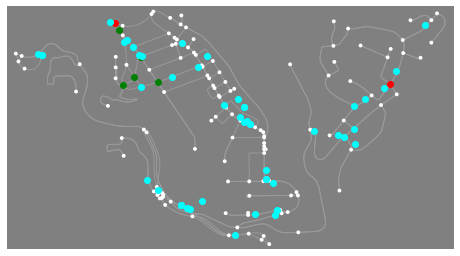

In [102]:
"""
One iteration to show to Dr. Li
"""
for car in list_of_vehicles:

    nodes_info = update_nodes_info()

    status = car.get_status()
    node_state = nodes_info[status["CurrentNode"]]
    node_id = status["CurrentNode"]
    car_index = list_of_vehicles.index(car)

    # Check if the car is on a node
    if status["OnNode"]:

        # Case 1: Traffic light
        if node_state["IsTrafficLight"]:

            # Signal 0 - green, 1 - red
            traffic_light_signal = node_state["TrafficLight"].state
            if traffic_light_signal:
                continue # Skip this iteration if waiting under red light
            else:
                car.iter_to_target()

        # Case 2: No traffic light
        else:

            # The car is the only car
            if len(node_state["Cars"]) <= 1:
                car.iter_to_target()

            # If there are other cars
            else:
                if node_state["Cars"].index(car_index) == 0:
                    car.iter_to_target()
                else:
                    car.wait(2)


    else:
        car.iter_to_target()
        
fig, ax = ox.plot_graph(G, show=False, close=False)
ax.set_facecolor('grey')

for t in nodes_info.values():
    if t["IsTrafficLight"]:
        t["TrafficLight"].draw_on_map(ax)
for c in list_of_vehicles:
    c.draw_on_map(ax)

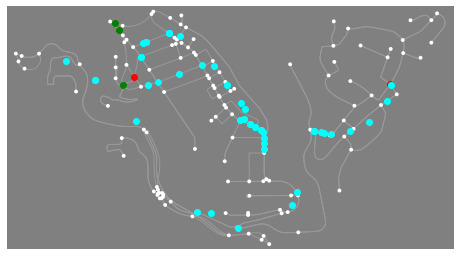

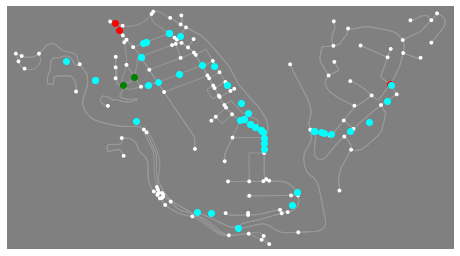

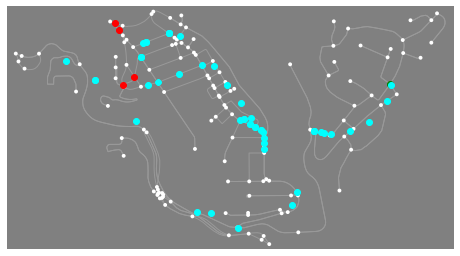

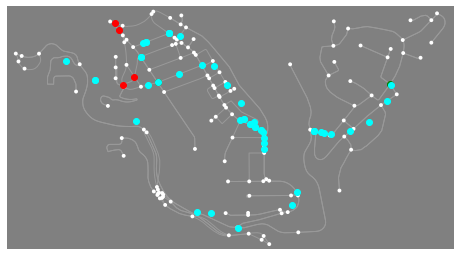

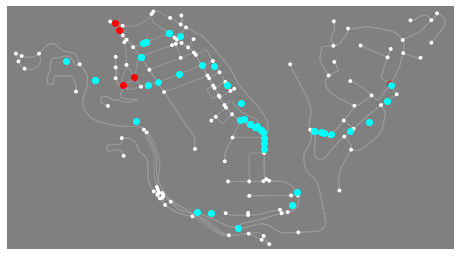

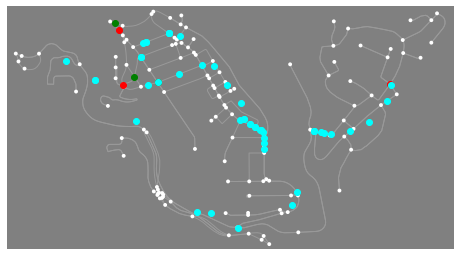

In [48]:
"""
Animate the simulation
"""
nodes_info = update_nodes_info()

fig, ax = ox.plot_graph(G, show=False, close=False)
ax.set_facecolor('grey')

for t in nodes_info.values():
    if t["IsTrafficLight"]:
        t["TrafficLight"].draw_on_map(ax)
for c in list_of_vehicles:
    c.draw_on_map(ax)

def animate(i):
    # One Iteration
    for car in list_of_vehicles:

        nodes_info = update_nodes_info()

        status = car.get_status()
        node_state = nodes_info[status["CurrentNode"]]
        node_id = status["CurrentNode"]
        car_index = list_of_vehicles.index(car)

        # Check if the car is on a node
        if status["OnNode"]:

            # Case 1: Traffic light
            if node_state["IsTrafficLight"]:

                # Signal 0 - green, 1 - red
                traffic_light_signal = node_state["TrafficLight"].state
                if traffic_light_signal:
                    continue # Skip this iteration if waiting under red light
                else:
                    car.iter_to_target()

            # Case 2: No traffic light
            else:

                # The car is the only car
                if len(node_state["Cars"]) <= 1:
                    car.iter_to_target()

                # If there are other cars
                else:
                    if node_state["Cars"].index(car_index) == 0:
                        car.iter_to_target()
                    else:
                        car.wait(2)


        else:
            car.iter_to_target()
            
        # DRAW
        fig, ax = ox.plot_graph(G, show=False, close=False)
        ax.set_facecolor('grey')
        for t in nodes_info.values():
            if t["IsTrafficLight"]:
                t["TrafficLight"].draw_on_map(ax)
        for c in list_of_vehicles:
            c.draw_on_map(ax)
        
        return ax

for i in range(5):
    animate(i)
anim = animation.FuncAnimation(fig, animate, frames=50, interval=1)
# Show the animation
plt.show()
           

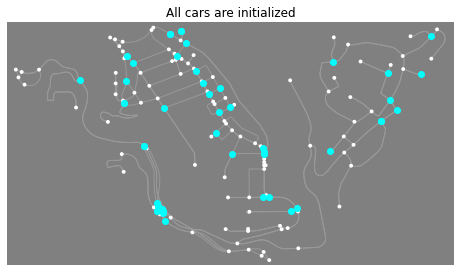

In [11]:
fig, ax = ox.plot_graph(G, show=False, close=False)
ax.set_facecolor('grey')

ax.set_title("All cars are initialized")

for i in list_of_vehicles:
    i.draw_on_map(ax)

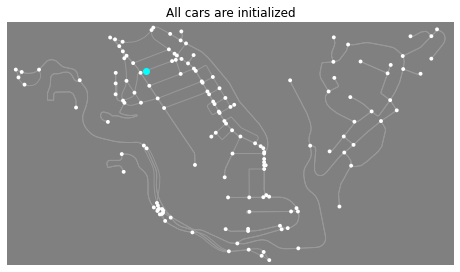

In [24]:
fig, ax = ox.plot_graph(G, show=False, close=False)
ax.set_facecolor('grey')

ax.set_title("All cars are initialized")

list_of_vehicles[0].iter_to_target()
list_of_vehicles[0].draw_on_map(ax)

In [17]:
nodes_info = update_nodes_info()
print(status)
print("node info from the loop", node_state)
print (car_index)
print (status["CurrentNode"])

{'CurrentNode': 991294757, 'CurrentPosition': array([114.1854807,  22.269173 ]), 'TargetNode': 1012752029, 'TargetPosition': array([114.1833462,  22.2696516]), 'OnNode': True}
node info from the loop {'Cars': [0, 13], 'IsTrafficLight': False}
1
991294757


In [31]:
print("node info from the dict", nodes_info[status["CurrentNode"]])

node info from the dict {'Cars': [49], 'IsTrafficLight': False}


1623825212 297165938
True


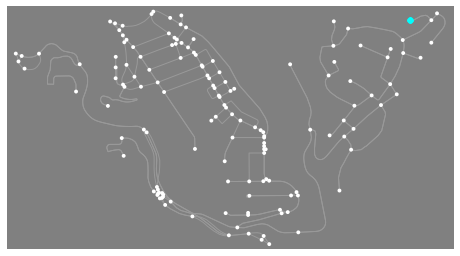

In [75]:
fig, ax = ox.plot_graph(G, show=False, close=False)
ax.set_facecolor('grey')

xxx, yyy = get_position_of_node(G, 1623825212) 
ax.scatter(xxx, yyy, c = "red")

"""xxx, yyy = get_position_of_node(G, 523778989)
ax.scatter(xxx, yyy, c = "red")"""

#car.draw_on_map(ax)
car.get_status()

list_of_vehicles[30].draw_on_map(ax)
print (list_of_vehicles[30].current_node, list_of_vehicles[27].current_node)
print (list_of_vehicles[30].get_status()["OnNode"])

In [ ]:
"""
Init traffic simulation
"""

traffic_jam = {} # Key - node ID, Value - list of cars 

"""

"""
signal_states = {}
for node in signal_list:
    signal_states = random.randint(0, 1)



In [20]:
tsutsenya = Car (G, nodesList[0], nodesList[3])
print(tsutsenya.current_position)

[114.1794367  22.2688338]


[8394547231, 4858149666, 635737209, 232221586, 232221594, 239989632]


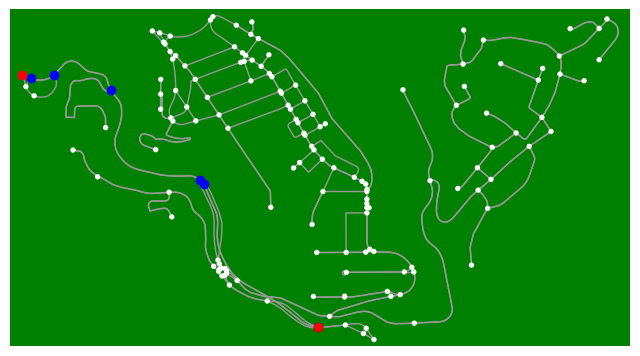

In [21]:
fig, ax = ox.plot_graph(G, show=False, close=False)
ax.set_facecolor('green')

print(tsutsenya.all_target_nodes)

for i in tsutsenya.all_target_nodes:
    coordinates = get_position_of_node(G, i)
    xx1, yy1 = coordinates
    ax.scatter(xx1, yy1, c='blue')

    
xx1, yy1 = tsutsenya.current_position
ax.scatter(xx1, yy1, c='red')

xx1, yy1 = tsutsenya.target_position
ax.scatter(xx1, yy1, c='red')


[114.18120937  22.26861586]


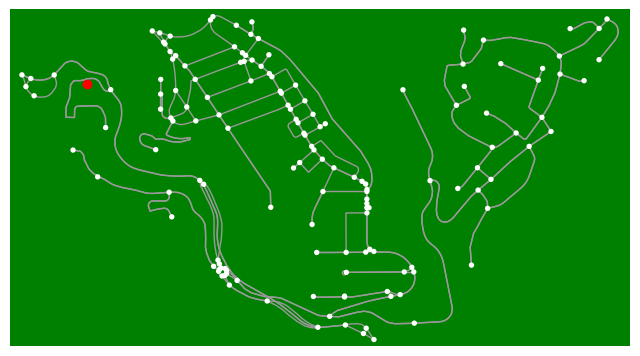

In [32]:
#tsutsenya.wait(3)

tsutsenya.iter_to_target()
print(tsutsenya.current_position)

fig, ax = ox.plot_graph(G, show=False, close=False)
ax.set_facecolor('green')
xx1, yy1 = tsutsenya.current_position
ax.scatter(xx1, yy1, c='red')

In [25]:
print(tsutsenya.finished())
print(tsutsenya.current_node)
print(tsutsenya.target_node)
print(tsutsenya.all_target_nodes)

False
8394547231
239989632
[4858149666, 635737209, 232221586, 232221594, 239989632]


[1012752115, 1623824957, 1623824977, 1623824989, 1623824999, 1623825064]


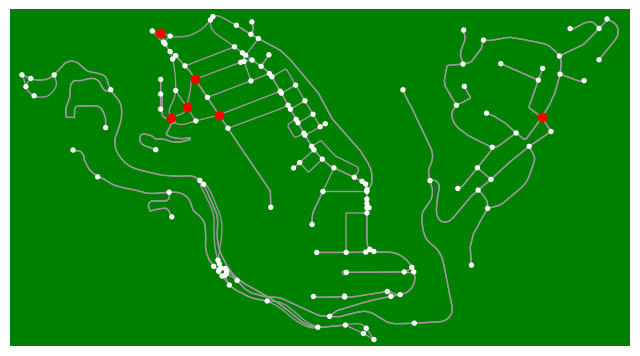

In [90]:
fig, ax = ox.plot_graph(G, show=False, close=False)
ax.set_facecolor('green')

for i in signal_nodes.index:
    xx1, yy1 = get_position_of_node(G, i)
    ax.scatter(xx1, yy1, c='red')

Int64Index([1012752115, 1623824957, 1623824977, 1623824989, 1623824999,
            1623825064],
           dtype='int64', name='osmid')